In [3]:
import cv2, os, glob
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from skimage.color import rgb2gray

#Definitely need to change this. Just used this to get over the initial hurdle
def extract_frames(video_path, frame_rate=13, output_dir="frames"):
  """Extracts frames from a video file and saves them with unique names.

  Args:
    video_path: The path to the video file.
    frame_rate: The desired frame rate for the extracted frames.
    output_dir: The directory to save the extracted frames.

  Returns:
    A list of extracted frames.
  """

  cap = cv2.VideoCapture(video_path)

  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_interval = frame_count // frame_rate

  frames = []
  for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
      break
    if i % frame_interval == 0:
      frames.append(frame)

  # Create the output directory if it doesn't exist
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  # Save the extracted frames with unique names
  for i, frame in enumerate(frames, start = 1): #indicate starting no.
    filename = f"LipoKDEL1ug_biotin_no drug_live_5min1h_frame_{i:02d}.jpg"  #0 refers to adding leading zeros if needed, and 2 specifies the minimum character in the number which is 2. single digit no. will have leading zeros added to it.
    total_fluorescence.append(img.sum())
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, frame)

  return frames

# Extract frames from the video file
current_directory = os.getcwd()
video_path = os.path.join(current_directory, "LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi")
frames = extract_frames(video_path)

print(f"Extracted {len(frames)} frames.")

In [4]:
#Step 1: split into images

#find videos
print(f'Current directory: {os.getcwd()}')

path_to_videos = glob.glob(os.path.join('Videos','*.avi'))
print(path_to_videos, '-'*10, sep = '\n')
#create required directories
def makefolders(path):
    folder = os.path.split(path) #create folders for extracting all images
    folder = os.path.splitext(folder[-1])
    folder_create = os.path.join('Videos',folder[0])
    if os.path.exists(folder_create) == False:
        os.mkdir(folder_create)
    else:
        pass
    return folder_create

#navigate into folder for the image and save images
def saveimages(path, dir_name):
    cam = cv2.VideoCapture(path) #access the video. Idk how this actually works
    count, success = 0, True
    while success:
        success, image = cam.read() #access next image of the video
        if not cam.isOpened():
            print(f"Error: Could not open video file {path}")
        os.chdir(dir_name) #change directory so that it saves into the directory that we want to save into
        if success:
            folder = os.path.split(dir_name)
            if os.path.exists(f'{folder[-1]}_frame_{count:02}.jpg') == False:
                cv2.imwrite(f'{folder[-1]}_frame_{count:02}.jpg', image)
                count+=1
            else:
                print(f'Image {folder[-1]}_frame_{count:02}.jpg already exists, skipping save')
                count+=1
        else:
            print('Image failed to save')
        os.chdir(os.path.join('..','..'))
    cam.release()
    print(f'Current directory: {os.getcwd()} \n Completed {path}\n--------------------')

Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project
['Videos\\0.5ugDNA_drug10uM_5min45min_1.avi', 'Videos\\0.75ugDNA_drug10uM_5min45min_1.avi', 'Videos\\1ugDNA_drug10uM_5min45min_1.avi', 'Videos\\LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi', 'Videos\\LipoKDEL1ug_biotin_no drug_live_5min1h.avi', 'Videos\\XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h.avi', 'Videos\\XtremeStr-li1.5ug_biotin_no drug_live_5min45min.avi']
----------


In [6]:
#this extracts images by calling the functions defined above
for path in path_to_videos:
    dir_name = makefolders(path)
    saveimages(path, dir_name)

Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\0.5ugDNA_drug10uM_5min45min_1.avi
--------------------
Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\0.75ugDNA_drug10uM_5min45min_1.avi
--------------------
Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\1ugDNA_drug10uM_5min45min_1.avi
--------------------
Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi
--------------------
Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\LipoKD

type(img)=<class 'str'>


TypeError: Image data of dtype <U51 cannot be converted to float

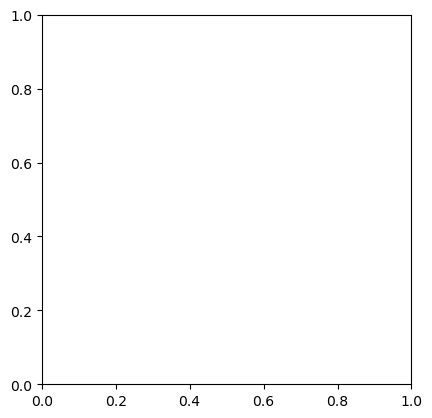

In [37]:
cwd = os.getcwd() #getting current working directory
video_folders = ['LipoKDEL1ug_biotin_no drug_live_5min1h', 'LipoKDEL1ug_biotin_drug25uM_live_5min1h', 'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h',
              'XtremeStr-li1.5ug_biotin_no drug_live_5min45min', '0.5ugDNA_drug10uM_5min45min_1', '0.75ugDNA_drug10uM_5min45min_1', '1ugDNA_drug10uM_5min45min_1']

#asking it to iterate through each folder in video_folders
for video_folders in video_folders:
    subdir_path = os.path.join(cwd, 'Videos', video_folders) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith(('.jpg')): #filter for only .jpg files
                # img_gray = rgb2gray(img)
                # plt.imshow(img, cmap='jet')
                # plt.colorbar()
                print(f'{type(img)=}')
                plt.imshow(img)

    else:
        print(f'Subdirectory {video_folders} not found')

cwd = os.getcwd()
img_dir = os.path.join(cwd, "LipoKDEL1ug_biotin_no drug_live_5min1h_frames") #access my cwd, this indicated folder
img_data = plt.imread('LipoKDEL1ug_biotin_no drug_live_5min1h_frame_01.jpg') #importing the first frame
img_gray = rgb2gray(img_data) #converting to grayscale, so easier to deal with
plt.imshow(img_gray, cmap='jet')
plt.colorbar()

In [17]:
print(f'{type(img_data)=}', 
      f'{img_data.shape=}', #dimension of image, 1D array.
      f'{img_data.min()=}', #tells us the dimmest pixel, 0, background noise
      f'{img_data.max()=}', #brightest pixel value, 255 as we converted to gray_scale
      f'{img_data.sum()=}', #sums all the overall brightness of pixels in the image
      sep='\n')

type(img_data)=<class 'numpy.ndarray'>
img_data.shape=(3145728,)
img_data.min()=0
img_data.max()=255
img_data.sum()=4578101


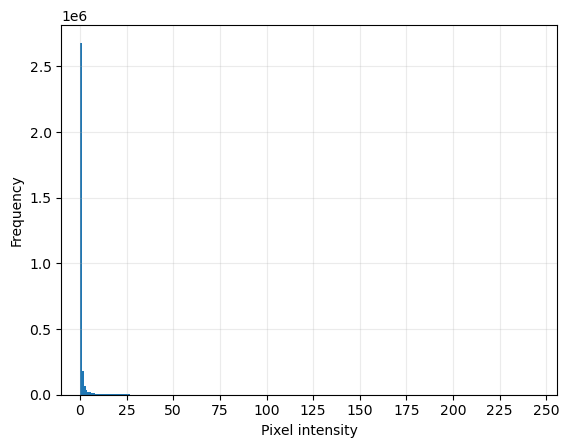

In [16]:
img_data = img_data.flatten() #converting it to 1d array
plt.hist(img_data, bins = 256) #uint8 range is 0-255
plt.xlim(-10, 256) #change so can observe those at 0 better

ticks = [i for i in range(0, 256, 25)] #using list comprehension, start 0, end 256 in intervals of 25

plt.xticks(ticks) #setting x intervals
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.grid(alpha = 0.25)
plt.show()

In [28]:
total_fluorescence = []
# conditions = ['LipoKDEL1ug_biotin_no drug_live_5min1h_frames",
#     'LipoKDEL1ug_biotin_drug25uM_live_5min1h_frames',
#     'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frames']

for i in range(1, 13+1):
    cwd = os.getcwd()
    img_dir = os.path.join(cwd, 'LipoKDEL1ug_biotin_no drug_live_5min1h_frames') #access my cwd, this indicated folder
    img_path = os.path.join(img_dir, f'LipoKDEL1ug_biotin_no drug_live_5min1h_frame_{i:02}.jpg')
    img = io.imread(img_path) #0 refers to adding leading zeros if needed, and 2 specifies the minimum character in the number which is 2. single digit no. will have leading zeros added to it.
    total_fluorescence.append(img.sum())

print(total_fluorescence) #sanitary check

[4578101, 5465947, 4992879, 4265734, 3501425, 3121450, 3545833, 3263858, 2894751, 2952973, 2785513, 2340890, 2263633]


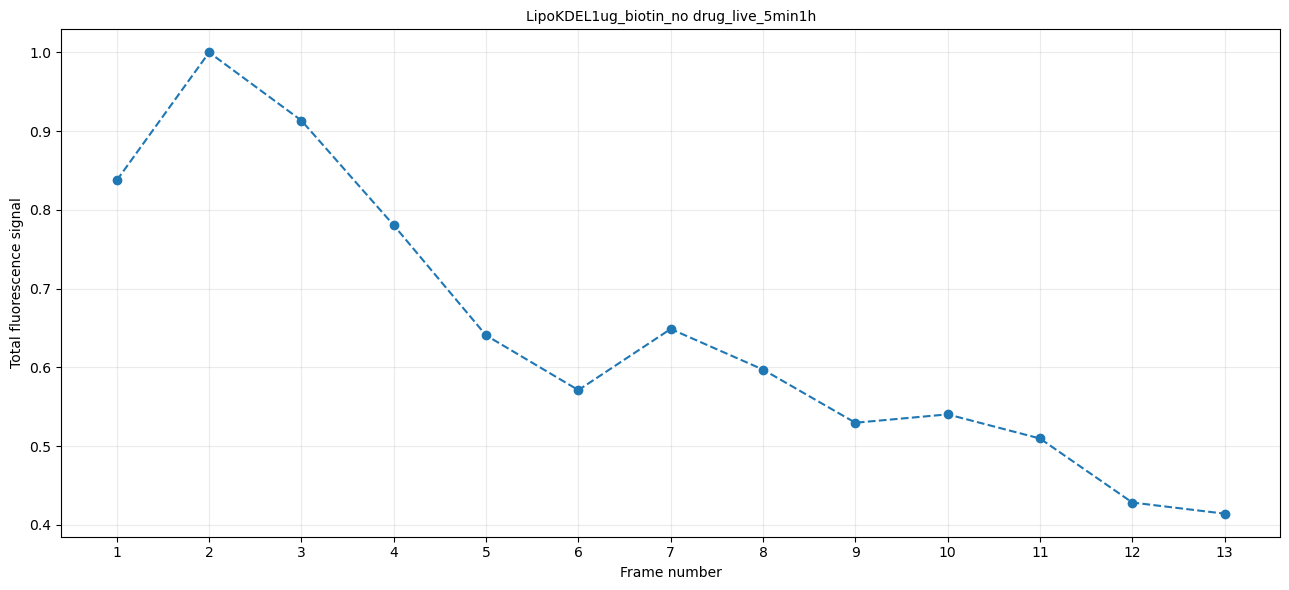

In [32]:
x = range(1,14) #This needs to match the number of total_fluorescence indexes
y = total_fluorescence / max(total_fluorescence) #Normalised to the img with the highest total brightness, as the highest datapoint = 1

#plotting segment
plt.figure(figsize = (13, 6)) #setting the figure size, has to be before plt.plot
plt.plot(x, y, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.

#Labels & aesthetics
plt.xticks(x) #this makes it show every tick in X axis
plt.xlabel('Frame number', fontsize = 10)
plt.ylabel('Total fluorescence signal', fontsize = 10)
plt.grid(alpha = .25)
plt.title('LipoKDEL1ug_biotin_no drug_live_5min1h', fontsize = 10)

plt.tight_layout() #trying out
plt.show()